<a href="https://colab.research.google.com/github/laurenwinslett/helloAI/blob/main/assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import time
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Define convolutional model
# Build the neural network, expand on top of nn.Module
# adapted from https://towardsdatascience.com/build-a-fashion-mnist-cnn-pytorch-style-efb297e22582
class ConvNetwork(nn.Module):
	def __init__(self):
		super().__init__()
		
		# define layers
		self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
		self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
		
		self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
		self.fc2 = nn.Linear(in_features=120, out_features=60)
		self.out = nn.Linear(in_features=60, out_features=10)

	# define forward function
	def forward(self, t):
		# conv 1
		t = t.cuda()
		t = self.conv1(t)
		t = F.relu(t)
		t = F.max_pool2d(t, kernel_size=2, stride=2)
		
		# conv 2
		t = t.cuda()
		t = self.conv2(t)
		t = F.relu(t)
		t = F.max_pool2d(t, kernel_size=2, stride=2)
		
		# fc1
		t = t.cuda()
		t = t.reshape(-1, 12*4*4)
		t = self.fc1(t)
		t = F.relu(t)
		
		# fc2
		t = t.cuda()
		t = self.fc2(t)
		t = F.relu(t)
		
		# output
		t = t.cuda()
		t = self.out(t)
		# don't need softmax here since we'll use cross-entropy as activation.
		return t

def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = F.cross_entropy(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# modified from https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html
# get our competing devices ready ... presumably cpu would somehow trigger the 16 core neural processors ... but I doubt it
# mps uses the 48 core gpu instead
gpu_device = torch.device("cuda")
cpu_device = torch.device("cpu")
xla_device = torch.device("xla")

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
	
# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# first hyperparam
batch_size = 64
	
# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
	
# Show some sample data
for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
	

# sample code for working with m1
   # Create a Tensor directly on the mps device
   #x = torch.ones(5, device=mps_device)
   # Or
   #x = torch.ones(5, device="mps")
   # Any operation happens on the GPU
   #y = x * 2

   # Move your model to mps just like any other device
model = ConvNetwork().to(xla_device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print("starting timer for training ConvNetwork using MPS...")
start = time.time()
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, xla_device)
print(f"completed training in ... {time.time()-start}s")

print("starting timer for testing using MPS...")
start = time.time()
test(test_dataloader, model, loss_fn, xla_device)
print(f"completed testing in ... {time.time()-start}s")

100%|██████████| 26421880/26421880 [00:01<00:00, 15044771.54it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 272199.90it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4985076.49it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15281158.52it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


RuntimeError: ignored

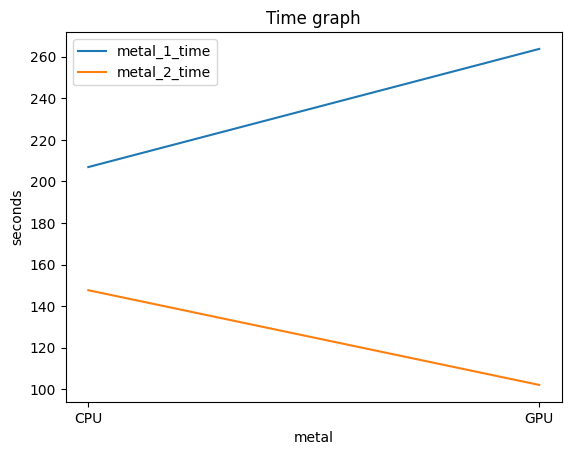

In [ ]:
# Metal 1
# CPU Training time: 206.92 Accuracy: 80.7%
# GPU Training time: 263.75 Accuracy: 80.8%
# TPU - not supported

# Metal 2
# CPU Training time: 147.67 Accuracy: 87.9%
# GPU Training time: 102.11 Accuracy: 87.6%
# TPU - not supported

import matplotlib.pyplot as plt
 
x = ["CPU", "GPU"]
Metal1time  = [206.92, 263.75]
Metal1acc = [80.7, 80.8]
Metal2time = [147.67, 102.11]
Metal2acc = [87.9, 87.6]

plt.plot(x, Metal1time, label="metal_1_time")
plt.plot(x, Metal2time, label="metal_2_time")
plt.plot()

plt.xlabel("metal")
plt.ylabel("seconds")
plt.title("Time graph")
plt.legend()
plt.show()

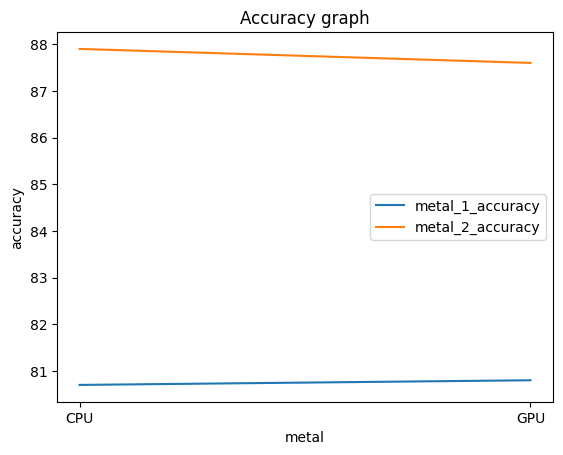

In [ ]:
import matplotlib.pyplot as plt
 
x = ["CPU", "GPU"]
Metal1time  = [206.92, 263.75]
Metal1acc = [80.7, 80.8]
Metal2time = [147.67, 102.11]
Metal2acc = [87.9, 87.6]

plt.plot(x, Metal1acc, label="metal_1_accuracy")
plt.plot(x, Metal2acc, label="metal_2_accuracy")
plt.plot()

plt.xlabel("metal")
plt.ylabel("accuracy")
plt.title("Accuracy graph")
plt.legend()
plt.show()